In [1]:
#Libraries 
import pandas as pd
import scipy.stats as st
import numpy as np
import statsmodels.stats.power as power_tools #new 
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch #new 

In [2]:
#reading a dataset for demographics 
df_demo = pd.read_csv("../data/raw/df_final_demo.txt", sep="|")
df_demo

,"client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth"
0,"836976,6.0,73.0,60.5,U,2.0,45105.3,6.0,9.0"
1,"2304905,7.0,94.0,58.0,U,2.0,110860.3,6.0,9.0"
2,"1439522,5.0,64.0,32.0,U,2.0,52467.78999999999,..."
3,"1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0"
4,"5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0"
...,...
70604,"7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0"
70605,"8981690,12.0,148.0,31.0,M,2.0,101867.069999999..."
70606,"333913,16.0,198.0,61.5,F,2.0,40745.0,3.0,3.0"
70607,"1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0"


In [3]:
#Understanding the customers demographics, enagement pattern before they did A/B testing 
demo_df = pd.read_csv(
    "../data/raw/df_final_demo.txt",
    sep=','  
)

demo_df.describe ()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,7.060900e+04,70595.000000,70595.000000,70594.000000,70595.000000,7.059500e+04,70595.000000,70595.000000
mean,5.004992e+06,12.052950,150.659367,46.442240,2.255528,1.474452e+05,3.382478,5.566740
std,2.877278e+06,6.871819,82.089854,15.591273,0.534997,3.015087e+05,2.236580,2.353286
min,1.690000e+02,2.000000,33.000000,13.500000,1.000000,1.378942e+04,0.000000,1.000000
25%,2.519329e+06,6.000000,82.000000,32.500000,2.000000,3.734683e+04,1.000000,4.000000
50%,5.016978e+06,11.000000,136.000000,47.000000,2.000000,6.333290e+04,3.000000,5.000000
75%,7.483085e+06,16.000000,192.000000,59.000000,2.000000,1.375449e+05,6.000000,7.000000
max,9.999839e+06,62.000000,749.000000,96.000000,8.000000,1.632004e+07,7.000000,9.000000


In [4]:
#Splitting up Tenure (in years) to 5 groups (according to insurance company standard + this dataframe itself) 
tenure_bins = [0, 5, 10, 20, 40, 62]
tenure_labels = ['New Business', 'Early', 'Mature', 'Veteran', 'More Veteran']
demo_df['Tenure_Group'] = pd.cut(demo_df['clnt_tenure_yr'], bins=tenure_bins, labels=tenure_labels)
demo_df['Tenure_Group'].value_counts()

Tenure_Group
Mature          26394
Early           22224
New Business    12172
Veteran          9731
More Veteran       74
Name: count, dtype: int64

In [5]:
# Group by your new bins and look at the mean for each metric
tenure_summary = demo_df.groupby('Tenure_Group', observed=False).agg({
    'calls_6_mnth': 'mean',
    'logons_6_mnth': 'mean',
    'bal': 'mean'
}).round(2)

print(tenure_summary)

              calls_6_mnth  logons_6_mnth        bal
Tenure_Group                                        
New Business          3.34           5.53   89366.01
Early                 3.36           5.55  114262.34
Mature                3.29           5.46  151664.68
Veteran               3.73           5.92  282877.11
More Veteran          3.77           5.93  352062.43


In [6]:
# Sorting tenure bins by number of logons, then calls (in the last 6 months) 
tenure_summary_sorted = tenure_summary.sort_values(
    by=['logons_6_mnth', 'calls_6_mnth'], 
    ascending=False
)

print(tenure_summary_sorted)

              calls_6_mnth  logons_6_mnth        bal
Tenure_Group                                        
More Veteran          3.77           5.93  352062.43
Veteran               3.73           5.92  282877.11
Early                 3.36           5.55  114262.34
New Business          3.34           5.53   89366.01
Mature                3.29           5.46  151664.68


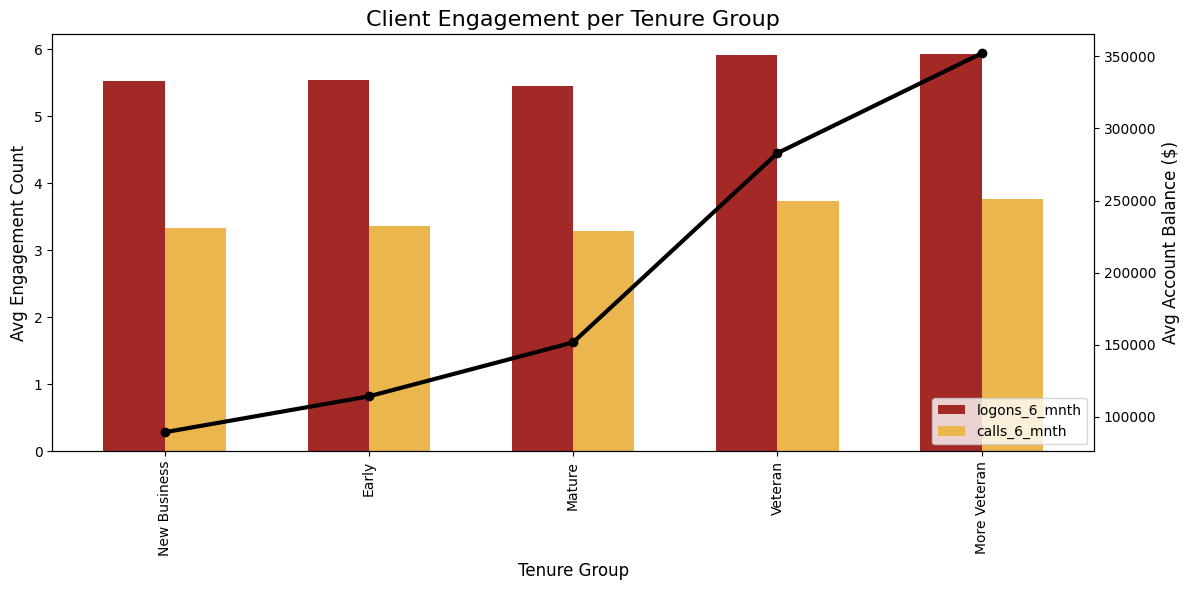

In [66]:
#Clients' General Engagement Data before A/B Testing was conducted, more tenure there is, more phone calls and logons per 6 months
ordered_labels = ['New Business', 'Early', 'Mature', 'Veteran', 'More Veteran']
tenure_summary = tenure_summary.reindex(ordered_labels)

fig, ax1 = plt.subplots(figsize=(12, 6))

tenure_summary[['logons_6_mnth', 'calls_6_mnth']].plot(kind='bar', ax=ax1, color=['#a32927', '#eab64d'], width=0.6)
ax1.set_ylabel('Avg Engagement Count', fontsize=12)
ax1.set_xlabel('Tenure Group', fontsize=12)
ax1.legend(loc='lower right')

ax2 = ax1.twinx()
ax2.plot(tenure_summary.index, tenure_summary['bal'], color='black', marker='o', linewidth=3, label='Avg Balance ($)')
ax2.set_ylabel('Avg Account Balance ($)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Client Engagement per Tenure Group', fontsize=16)
fig.tight_layout()
plt.show()

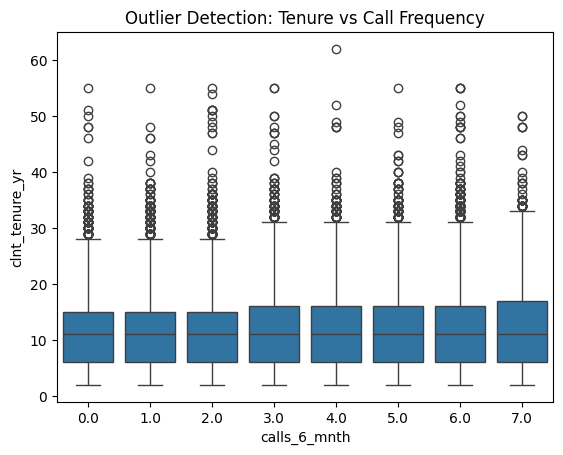

In [8]:
#An attempt to assess outliers as well as statement 'longer the tenure, more calls' which seem to be confirmed 
#Also less outliers as the number of tenure increases) 
sns.boxplot(data=demo_df, x='calls_6_mnth', y='clnt_tenure_yr')
plt.title('Outlier Detection: Tenure vs Call Frequency')
plt.show()

In [9]:
#Reading a dataset
final_df = pd.read_csv(
    '../data/raw/df_final_experiment_clients.txt',
    sep=','  
)

display (final_df) 

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


In [10]:
#Reading a dataset 1 
pt1_df = pd.read_csv(
    '../data/raw/df_final_web_data_pt_1.txt',
    sep=','  
)
display (pt1_df)

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
343136,2443347,465784886_73090545671,136329900_10529659391_316129,confirm,2017-03-31 15:15:46
343137,2443347,465784886_73090545671,136329900_10529659391_316129,step_3,2017-03-31 15:14:53
343138,2443347,465784886_73090545671,136329900_10529659391_316129,step_2,2017-03-31 15:12:08
343139,2443347,465784886_73090545671,136329900_10529659391_316129,step_1,2017-03-31 15:11:37


In [11]:
#Reading a dataset 2 
pt2_df = pd.read_csv(
    '../data/raw/df_final_web_data_pt_2.txt',
    sep=','  
)
display (pt2_df)

,client_id,visitor_id,visit_id,process_step,date_time
0,763412,601952081_10457207388,397475557_40440946728_419634,confirm,2017-06-06 08:56:00
1,6019349,442094451_91531546617,154620534_35331068705_522317,confirm,2017-06-01 11:59:27
2,6019349,442094451_91531546617,154620534_35331068705_522317,step_3,2017-06-01 11:58:48
3,6019349,442094451_91531546617,154620534_35331068705_522317,step_2,2017-06-01 11:58:08
4,6019349,442094451_91531546617,154620534_35331068705_522317,step_1,2017-06-01 11:57:58
...,...,...,...,...,...
412259,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
412260,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
412261,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
412262,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


In [12]:
#combining testing result 1 & 2 
combined_df = pd.concat([pt1_df, pt2_df], axis=0)

combined_df_reset = pd.concat([pt1_df, pt2_df], ignore_index=True)

display (combined_df) 

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
412259,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
412260,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
412261,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
412262,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


In [13]:
display (demo_df)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Tenure_Group
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Early
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,New Business
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Mature
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Mature
...,...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,New Business
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,Mature
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,Mature
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,Veteran


In [14]:
#Merging demo dataframe and combined df by client_id 
combined_df_2 = pd.merge(
    left=demo_df,        
    right=combined_df,   
    on='client_id',     
    how='left'           
)
display (combined_df_2)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Tenure_Group,visitor_id,visit_id,process_step,date_time
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:51:13
1,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:47:50
2,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:46:45
3,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,step_3,2017-04-02 11:23:08
4,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,step_2,2017-04-02 11:22:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449826,5602139,21.0,254.0,59.5,F,3.0,157498.73,7.0,7.0,Veteran,962766819_57063135389,158544612_4105226940_43043,confirm,2017-04-05 11:48:02
449827,5602139,21.0,254.0,59.5,F,3.0,157498.73,7.0,7.0,Veteran,962766819_57063135389,158544612_4105226940_43043,step_3,2017-04-05 11:44:07
449828,5602139,21.0,254.0,59.5,F,3.0,157498.73,7.0,7.0,Veteran,962766819_57063135389,158544612_4105226940_43043,step_2,2017-04-05 11:43:10
449829,5602139,21.0,254.0,59.5,F,3.0,157498.73,7.0,7.0,Veteran,962766819_57063135389,884309593_49820690623_654151,step_1,2017-04-05 11:41:32


In [15]:
#Dropping duplicates 
combined_df_2 = combined_df_2.drop_duplicates(subset=['client_id']) 

In [16]:
#Dropping null values
combined_df_2 = combined_df_2.dropna(how='any')

In [17]:
#Checking if cleaning worked 
display (combined_df_2)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Tenure_Group,visitor_id,visit_id,process_step,date_time
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:51:13
11,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Early,336210275_56978226960,724930510_65323235593_692754,confirm,2017-05-21 11:07:16
17,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,New Business,245908175_84333642537,898099666_87299892721_263146,step_3,2017-04-06 09:29:59
22,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Mature,391202328_71710993352,71954691_44810191073_495385,start,2017-04-06 19:03:46
23,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Mature,432077852_35036160885,942996157_39527225999_589383,start,2017-06-14 14:22:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449793,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,New Business,43214017_97463037638,836828058_85095473377_98507,start,2017-04-03 21:41:39
449804,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,Mature,235892744_2995807940,458308265_80160772759_795974,confirm,2017-05-31 06:22:48
449812,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,Mature,405457094_54883289172,10432687_78618454141_814606,confirm,2017-04-09 13:03:40
449817,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,Veteran,110929964_38003873994,504342110_43310803922_587933,start,2017-04-06 14:22:03


In [18]:
#Dropping duplicated data but keeping the 'first'
combined_df_2 = combined_df_2.drop_duplicates(
    subset=['client_id'],
    keep='first'
)
display (combined_df_2) 

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Tenure_Group,visitor_id,visit_id,process_step,date_time
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:51:13
11,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Early,336210275_56978226960,724930510_65323235593_692754,confirm,2017-05-21 11:07:16
17,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,New Business,245908175_84333642537,898099666_87299892721_263146,step_3,2017-04-06 09:29:59
22,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Mature,391202328_71710993352,71954691_44810191073_495385,start,2017-04-06 19:03:46
23,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Mature,432077852_35036160885,942996157_39527225999_589383,start,2017-06-14 14:22:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449793,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,New Business,43214017_97463037638,836828058_85095473377_98507,start,2017-04-03 21:41:39
449804,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,Mature,235892744_2995807940,458308265_80160772759_795974,confirm,2017-05-31 06:22:48
449812,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,Mature,405457094_54883289172,10432687_78618454141_814606,confirm,2017-04-09 13:03:40
449817,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,Veteran,110929964_38003873994,504342110_43310803922_587933,start,2017-04-06 14:22:03


The demographics of the customers is below : 
clnt_tenure_yr	is 12 years, number of accoutns 2, avg age 47, most people with gender unspecified, more male than female 

In [19]:
#To understand the information on Vanguard testing demographics 
combined_df_2.describe ()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
count,7.059400e+04,70594.000000,70594.000000,70594.000000,70594.000000,7.059400e+04,70594.000000,70594.000000
mean,5.005026e+06,12.053007,150.659999,46.442240,2.255532,1.474467e+05,3.382469,5.566720
std,2.877289e+06,6.871850,82.090264,15.591273,0.535000,3.015106e+05,2.236595,2.353296
min,1.690000e+02,2.000000,33.000000,13.500000,1.000000,1.378942e+04,0.000000,1.000000
25%,2.519543e+06,6.000000,82.000000,32.500000,2.000000,3.734660e+04,1.000000,4.000000
50%,5.016974e+06,11.000000,136.000000,47.000000,2.000000,6.333459e+04,3.000000,5.000000
75%,7.483074e+06,16.000000,192.000000,59.000000,2.000000,1.375461e+05,6.000000,7.000000
max,9.999839e+06,62.000000,749.000000,96.000000,8.000000,1.632004e+07,7.000000,9.000000


In [20]:
#checking for unique values in gender, renaming gender column too 
combined_df_2['gendr'].unique ()

array(['U', 'M', 'F', 'X'], dtype=object)

In [21]:
#just show counts of gender 
combined_df_2['gendr'].value_counts()

gendr
U    24122
M    23724
F    22745
X        3
Name: count, dtype: int64

In [22]:
#frequency for the age 
combined_df_2.clnt_age.value_counts()

clnt_age
58.5    859
55.5    830
29.5    829
28.5    827
57.5    826
       ... 
96.0      2
14.0      2
94.5      1
95.5      1
13.5      1
Name: count, Length: 165, dtype: int64

In [23]:
#Age group split up 
age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['Minor', 'Young Adult', 'Middle Aged', 'Senior', 'Elderly']
combined_df_2['Age_Group'] = pd.cut(combined_df_2['clnt_age'], bins=age_bins, labels=age_labels)
combined_df_2.head(10)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Tenure_Group,visitor_id,visit_id,process_step,date_time,Age_Group
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:51:13,Elderly
11,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Early,336210275_56978226960,724930510_65323235593_692754,confirm,2017-05-21 11:07:16,Senior
17,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,New Business,245908175_84333642537,898099666_87299892721_263146,step_3,2017-04-06 09:29:59,Middle Aged
22,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Mature,391202328_71710993352,71954691_44810191073_495385,start,2017-04-06 19:03:46,Senior
23,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Mature,432077852_35036160885,942996157_39527225999_589383,start,2017-06-14 14:22:31,Middle Aged
24,3727881,5.0,71.0,30.5,U,2.0,23915.60,0.0,3.0,New Business,875448077_54387937735,717519432_65547872352_613051,confirm,2017-03-29 14:00:45,Middle Aged
31,272934,5.0,66.0,58.5,U,2.0,27021.42,2.0,5.0,New Business,227827901_46893415084,468902637_55778357932_556682,confirm,2017-04-05 16:53:48,Senior
36,388801,30.0,361.0,57.5,M,5.0,522498.72,1.0,4.0,Veteran,56607555_75044897582,247503697_11679931698_453228,confirm,2017-04-06 10:48:22,Senior
41,285619,30.0,369.0,67.5,M,2.0,299388.72,3.0,6.0,Veteran,667009768_32934260678,545534470_5635716155_93472,confirm,2017-03-29 11:57:25,Elderly
50,8198645,15.0,189.0,54.5,F,2.0,382303.83,6.0,9.0,Mature,82840443_57437149926,400364490_7666683185_180781,confirm,2017-03-30 12:32:11,Senior


In [24]:
#Combining both testing results 
merged_df = combined_df_2.merge(final_df, on='client_id', how='left')
merged_df

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Tenure_Group,visitor_id,visit_id,process_step,date_time,Age_Group,Variation
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Early,427070339_1413275162,228976764_46825473280_96584,confirm,2017-04-02 11:51:13,Elderly,Test
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Early,336210275_56978226960,724930510_65323235593_692754,confirm,2017-05-21 11:07:16,Senior,Control
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,New Business,245908175_84333642537,898099666_87299892721_263146,step_3,2017-04-06 09:29:59,Middle Aged,Test
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Mature,391202328_71710993352,71954691_44810191073_495385,start,2017-04-06 19:03:46,Senior,Test
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Mature,432077852_35036160885,942996157_39527225999_589383,start,2017-06-14 14:22:31,Middle Aged,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70589,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,New Business,43214017_97463037638,836828058_85095473377_98507,start,2017-04-03 21:41:39,Middle Aged,NaN
70590,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,Mature,235892744_2995807940,458308265_80160772759_795974,confirm,2017-05-31 06:22:48,Middle Aged,NaN
70591,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,Mature,405457094_54883289172,10432687_78618454141_814606,confirm,2017-04-09 13:03:40,Elderly,NaN
70592,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,Veteran,110929964_38003873994,504342110_43310803922_587933,start,2017-04-06 14:22:03,Elderly,NaN


In [25]:
#to assess customers' tenure max & min value 
merged_df['clnt_tenure_yr'].max() #62 
merged_df['clnt_tenure_yr'].min() #2 

np.float64(2.0)

In [26]:
#Tenure group split up 
tenure_bins = [0, 5, 10, 20, 40, 62]
tenure_labels = ['New Business', 'Early', 'Mature', 'Veteran', 'More Veteran']
merged_df['Tenure_Group'] = pd.cut(merged_df['clnt_tenure_yr'], bins=tenure_bins, labels=tenure_labels)
merged_df['Tenure_Group'].value_counts()

Tenure_Group
Mature          26394
Early           22223
New Business    12172
Veteran          9731
More Veteran       74
Name: count, dtype: int64

In [27]:
#Merging the df with testing result as well as 2 of the the participants datasts 
merged_df = combined_df_2.merge(
    final_df[['client_id', 'Variation']], 
    on='client_id',                      
    how='left'                            
)

***Ou's Analysis on time spent***

In [28]:
import pandas as pd
merged_df["date_time"] = pd.to_datetime(merged_df["date_time"])

In [29]:
datetime_df = merged_df.sort_values(
    ["visit_id", "date_time"]
)

In [30]:
datetime_df["time_diff_sec"] = (
    datetime_df
        .groupby("visit_id")["date_time"]
        .diff() # current time - previous time
        .dt.total_seconds() #change time to float eg. 0 days 00:00:20 ->20
)

In [31]:
datetime_df[["visit_id", "process_step", "time_diff_sec"]].head(10)

,visit_id,process_step,time_diff_sec
12213,100019538_17884295066_43909,confirm,NaN
40050,100022086_87870757897_149620,confirm,NaN
23596,100030127_47967100085_936361,start,NaN
21828,100057941_88477660212_944512,step_3,NaN
64415,100061345_677868293_127105,start,NaN
66921,100065579_58979991824_496649,confirm,NaN
40573,10006594_66157970412_679648,confirm,NaN
18000,100071743_53464757454_616703,start,NaN
37152,10007589_47780784567_391490,confirm,NaN
15783,100096068_8301717872_987164,step_1,NaN


In [32]:
#Per step time difference (Ou's) 
avg_time_per_step = (
    datetime_df
    .groupby(["Variation", "process_step"])["time_diff_sec"]
    .mean()
    .reset_index()
)

avg_time_per_step

,Variation,process_step,time_diff_sec
0,Control,confirm,712.831683
1,Control,start,611.923077
2,Control,step_1,408.777778
3,Control,step_2,805.666667
4,Control,step_3,1092.500000
5,Test,confirm,534.043478
6,Test,start,542.333333
7,Test,step_1,359.500000
8,Test,step_2,261.333333
9,Test,step_3,781.500000


#Ou's code 
completion_rate = (
    visit_completion
    .groupby("Variation")["completed"]
    .mean()
    .reset_index()
)

#completion_rate

#total number of people completed = test
#total number of pepople coplted = control 

df_web = df_web.merge(
    df_exp[["client_id", "Variation"]],
    on="client_id",
    how="inner"
)
df_web

***Completion Rate Stat Significant***
H0: The completion rate of the Test group is less than or equal to the completion rate of the Control group / The new design did not improve the completion rate.)

The difference between Test & Control are very large, rejecting null hypothesis and the new design directly positively influenced the completion rate. 
- Chi-square Statistic: 139.93
- P-value: 0.00000


(NOT TRUE : (There is no evidence that the Test group’s completion rate is greater than the Control group’s. In fact, the negative T-stat tells us the Test group performed significantly worse. P-value: 1.00, T-stat: -11.86)) 

In [33]:
#null hypothesis : the new design performing better was by chance and there is no correlation between new design and the testing
#p-value, the statistical test prerequisites, and other relevant statistical measures in your analysis.

#converting the string to number 
merged_df['done'] = (merged_df['process_step'] == 'step_3').astype(int)

# grouping the client by confirm 
client_outcomes = merged_df.groupby(['client_id', 'Variation'])['done'].max().reset_index()

#dividing test and control with the confirm condition 
control_group = client_outcomes[client_outcomes['Variation'] == 'Control']['done']
test_group = client_outcomes[client_outcomes['Variation'] == 'Test']['done']

# T-test 
t_stat, p_value = st.ttest_ind(test_group, control_group, alternative='greater')


print(f"P-value: {p_value:.5f}")
print(f"T-stat: {t_stat:.2f}")

P-value: 1.00000
T-stat: -11.86


In [34]:
import pandas as pd
from scipy import stats as stats

#contingency table creation by using crosstab 
contingency_table = pd.crosstab (client_outcomes['Variation'], client_outcomes['done'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p_val:.5f}")

Chi-square Statistic: 139.93
P-value: 0.00000


***Was there any difference in tenure between old and new design testing groups?***
Yes, but the difference is marginal, so randomisation for tenure is not worth re-testing. 
The results were T stat: 1.71, p-value: 0.04, Test Group had average tenure year of 11.98 years, Control Group was 12.09 years

In [35]:
#Test if the average client tenure (how long they've been with Vanguard) 
#of those engaging with the new process => Testing 
#is the same as those engaging with the old process => Control # Create a new dataframe with only the two columns I need 
tenure_subset = merged_df[['clnt_tenure_yr', 'Variation']].copy() 

#working out the mean of each Variation groups tenure years 
control_yr = tenure_subset[tenure_subset['Variation'] == 'Control']['clnt_tenure_yr'] 
test_yr = tenure_subset[tenure_subset['Variation'] == 'Test']['clnt_tenure_yr']

# T-test 
t_stat, p_value = st.ttest_ind(
    a=control_yr, 
    b=test_yr, 
    equal_var=False, 
    alternative='greater'
)
print (f"The results were T stat: {t_stat:.2f}, p-value: {p_value:.2f}, Test Group had average tenure year of {test_yr.mean():.2f} years, Control Group was {control_yr.mean():.2f} years")

The results were T stat: 1.71, p-value: 0.04, Test Group had average tenure year of 11.98 years, Control Group was 12.09 years


***Between groups (control and test), are the completion rates (number of customers who reached the end of a step out of total who started) in each step the same?***
=> No, Control Group had higher completion rate of 28.00% and the Test Group had lower a completion rate of 20.70%

In [36]:
#column with participants who have started 
merged_df['started'] = (merged_df['process_step'] == 'start').astype(int)

#grouped by started 
client_outcomes = merged_df.groupby(['client_id', 'Variation'])['started'].max().reset_index()

#counting the number of started participants grouped into Control & Test 
control_started = client_outcomes[client_outcomes['Variation'] == 'Control']['started']
test_started = client_outcomes[client_outcomes['Variation'] == 'Test']['started']

#totaling the number of started by Control & Test 
control_s_sum = control_started.sum ()
test_s_sum =  test_started.sum () 

#the same process as above, but this time by finished/reached to confirm stage 
merged_df['done'] = (merged_df['process_step'] == 'step_3').astype(int)
client_outcomes = merged_df.groupby(['client_id', 'Variation'])['done'].max().reset_index()
control_done = client_outcomes[client_outcomes['Variation'] == 'Control']['done']
test_done = client_outcomes[client_outcomes['Variation'] == 'Test']['done']
control_d_sum = control_done.sum()
test_d_sum = test_done.sum() 

control_survived =   control_d_sum /control_s_sum 
test_survived =   test_d_sum / test_s_sum
print (f"Control Group had completion rate of {control_survived:.2%} and the Test Group had a completion rate of {test_survived:.2%}")

Control Group had completion rate of 28.00% and the Test Group had a completion rate of 20.70%


***Are there difference between age groups?***
Generally, Young Adult has the highest completion rate, Minor, Middle Aged are generally 60% and the Senior & Elderly has 50% but the uplift between Control and Test are around the same across different Age Groups. 

In [37]:
#Completion rate by Age Group 
merged_df['date_time'] = pd.to_datetime(merged_df['date_time'])
merged_df = merged_df.sort_values(['client_id', 'date_time'])
merged_df['time_spent'] = merged_df.groupby('client_id')['date_time'].diff().dt.total_seconds()
age_time_analysis = merged_df.groupby(['Age_Group', 'Variation', 'process_step'])['time_spent'].mean().reset_index()
analysis_pivot = age_time_analysis.pivot(index=['Age_Group', 'process_step'], columns='Variation', values='time_spent')

merged_df['is_confirmed'] = (merged_df['process_step'] == 'confirm').astype(int)
client_success = merged_df.groupby(['client_id', 'Variation', 'Age_Group'])['is_confirmed'].max().reset_index()
completion_stats = client_success.groupby(['Age_Group', 'Variation'])['is_confirmed'].mean() * 100

print("Completion Rate (%) by Age Group:")
print(completion_stats)

C:\Users\akoki\AppData\Local\Temp\ipykernel_14136\807980785.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_time_analysis = merged_df.groupby(['Age_Group', 'Variation', 'process_step'])['time_spent'].mean().reset_index()
C:\Users\akoki\AppData\Local\Temp\ipykernel_14136\807980785.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  client_success = merged_df.groupby(['client_id', 'Variation', 'Age_Group'])['is_confirmed'].max().reset_index()
C:\Users\akoki\AppData\Local\Temp\ipykernel_14136\807980785.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futu

Completion Rate (%) by Age Group:
Age_Group    Variation
Minor        Control      52.173913
             Test         60.606061
Young Adult  Control      54.113079
             Test         64.745057
Middle Aged  Control      55.159918
             Test         62.798818
Senior       Control      51.366120
             Test         57.900459
Elderly      Control      44.099488
             Test         54.696827
Name: is_confirmed, dtype: float64


***Power Analysis : What will be the ideal sample size the next time?***
We will require to achieve the 62% completion rate, 317 participants. 

In [38]:
#Completion Rate, Minor to Middle Aged
control_rate = (52,54,55)
control_mean = np.mean(control_rate)
print (control_mean)  #0.51

test_rate = (60,64,62)
test_mean = np.mean(test_rate) 
print (test_mean)  #62

53.666666666666664
62.0


In [39]:
#Baseline Conversion Rate
CVR = 0.51
#Minimum Detectable Effect (MDE)/Target Conversion Rate
MDE = 0.62 
#Cohen's h, Effect size 
#Significance Level (alpha)
Alpha = 0.05 
#Statistical Power (beta), standard is 80% 
Beta = 0.80 
#Calculating Cohen's h (Effect Size), distance between 20, 28 
effect_size = 2 * (np.arcsin(np.sqrt(MDE)) - np.arcsin(np.sqrt(CVR)))

#Solve sample size 
analysis = power_tools.NormalIndPower()
n = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.80, ratio=1.0)
print (round(n)) 

317


In [40]:
from function import (
    load_and_concat_data,
    compute_completion_rate_by_variation,
    compute_avg_time_per_step_by_variation,
    compute_error_rate_by_variation
)

In [41]:
df_err = (
    combined_df
    .merge(final_df, on="client_id", how="inner")
    .dropna(subset=["Variation"])
    .copy()
)

df_err["date_time"] = pd.to_datetime(df_err["date_time"])

df_err = df_err.sort_values(["visit_id", "date_time"])

In [42]:
step_order = {
    "start": 0,
    "step_1": 1,
    "step_2": 2,
    "step_3": 3,
    "confirm": 4
}

df_err["step_num"] = df_err["process_step"].map(step_order)

df_err["step_diff"] = (
    df_err
    .groupby("visit_id")["step_num"]
    .diff()
)

In [43]:
df_err["error"] = df_err["step_diff"] < 0

In [44]:
visit_errors = (
    df_err
    .groupby(["visit_id", "Variation"])["error"]
    .any()
    .reset_index()
)

visit_errors.head()

,visit_id,Variation,error
0,100012776_37918976071_457913,Test,False
1,100019538_17884295066_43909,Test,True
2,100022086_87870757897_149620,Test,False
3,100030127_47967100085_936361,Control,False
4,100037962_47432393712_705583,Control,True


In [45]:
avg_time_per_step = (
    datetime_df
    .groupby(["Variation", "process_step"])["time_diff_sec"]
    .mean()
    .reset_index()
)

avg_time_per_step

,Variation,process_step,time_diff_sec
0,Control,confirm,712.831683
1,Control,start,611.923077
2,Control,step_1,408.777778
3,Control,step_2,805.666667
4,Control,step_3,1092.500000
5,Test,confirm,534.043478
6,Test,start,542.333333
7,Test,step_1,359.500000
8,Test,step_2,261.333333
9,Test,step_3,781.500000


In [46]:
display (merged_df)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Tenure_Group,visitor_id,visit_id,process_step,date_time,Age_Group,Variation,done,started,time_spent,is_confirmed
59758,169,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0,Veteran,201385055_71273495308,749567106_99161211863_557568,confirm,2017-04-12 20:23:09,Senior,NaN,0,0,NaN,1
40117,555,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,New Business,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,Young Adult,Test,0,0,NaN,1
1532,647,12.0,151.0,57.5,M,2.0,30525.80,0.0,4.0,Mature,66758770_53988066587,40369564_40101682850_311847,confirm,2017-04-12 15:47:45,Senior,Test,0,0,NaN,1
58453,722,11.0,143.0,59.5,F,2.0,22466.17,1.0,1.0,Mature,919259913_64837298108,984487154_55831795985_521110,confirm,2017-04-19 15:00:09,Senior,NaN,0,0,NaN,1
13138,934,9.0,109.0,51.0,F,2.0,32522.88,0.0,3.0,Early,810392784_45004760546,7076463_57954418406_971348,start,2017-04-18 02:38:52,Senior,Test,0,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30530,9999400,7.0,86.0,28.5,U,2.0,51787.04,0.0,3.0,Early,915967319_19082377501,288904166_90826265353_276104,confirm,2017-04-20 05:23:27,Young Adult,Test,0,0,NaN,1
3228,9999626,9.0,113.0,35.0,M,2.0,36642.88,6.0,9.0,Early,52633065_71189986073,182723364_27031318473_880901,step_1,2017-05-14 09:07:59,Middle Aged,Test,0,0,NaN,0
48744,9999729,10.0,124.0,31.0,F,3.0,107059.74,6.0,9.0,Early,604429154_69247391147,99583652_41711450505_426179,step_1,2017-04-05 13:41:04,Middle Aged,Test,0,0,NaN,0
8010,9999832,23.0,281.0,49.0,F,2.0,431887.61,1.0,4.0,Veteran,145538019_54444341400,472154369_16714624241_585315,step_1,2017-05-16 16:46:11,Senior,Test,0,0,NaN,0


In [47]:
#Prepping data for each steps, defining steps 
grouped = merged_df.groupby(["Variation","process_step"])["client_id"].nunique()
funnel_data = grouped.unstack()
steps_order = ['confirm','start', 'step_1', 'step_2', 'step_3']
funnel_data = funnel_data[steps_order]

In [48]:
#Step by step success rate table 
prob_df = pd.DataFrame(index=funnel_data.index)
prob_df['Start to Step 1'] = funnel_data['step_1'] / funnel_data['start'] 
prob_df['Step 1 to Step 2'] = funnel_data['step_2'] / funnel_data['step_1']
prob_df['Step 2 to Step 3'] = funnel_data['step_2'] / funnel_data['step_3']
prob_df['Step 3 to Confirm'] = funnel_data['step_3'] / funnel_data['confirm']
print (prob_df)
plot_read = prob_df.T

           Start to Step 1  Step 1 to Step 2  Step 2 to Step 3  \
Variation                                                        
Control           0.344871          0.510445          0.628635   
Test              0.305221          0.461347          0.680147   

           Step 3 to Confirm  
Variation                     
Control             0.148666  
Test                0.084462  


In [49]:
# 'Melt' the success probabilities
plot_data = prob_df.reset_index().melt(id_vars='Variation', var_name='Step', value_name='Success_Prob')

# Adding the 'Drop' probability 
plot_data['Drop_Prob'] = 1 - plot_data['Success_Prob']

# Create a specialised dataframe for the 'Stacked' look
melted_success = plot_data[['Variation', 'Step', 'Success_Prob']].copy()
melted_success['Status'] = 'Success'
melted_success.rename(columns={'Success_Prob': 'Probability'}, inplace=True)

melted_drop = plot_data[['Variation', 'Step', 'Drop_Prob']].copy()
melted_drop['Status'] = 'Drop'
melted_drop.rename(columns={'Drop_Prob': 'Probability'}, inplace=True)

final_plot_df = pd.concat([melted_success, melted_drop])
final_plot_df

,Variation,Step,Probability,Status
0,Control,Start to Step 1,0.344871,Success
1,Test,Start to Step 1,0.305221,Success
2,Control,Step 1 to Step 2,0.510445,Success
3,Test,Step 1 to Step 2,0.461347,Success
4,Control,Step 2 to Step 3,0.628635,Success
5,Test,Step 2 to Step 3,0.680147,Success
6,Control,Step 3 to Confirm,0.148666,Success
7,Test,Step 3 to Confirm,0.084462,Success
0,Control,Start to Step 1,0.655129,Drop
1,Test,Start to Step 1,0.694779,Drop


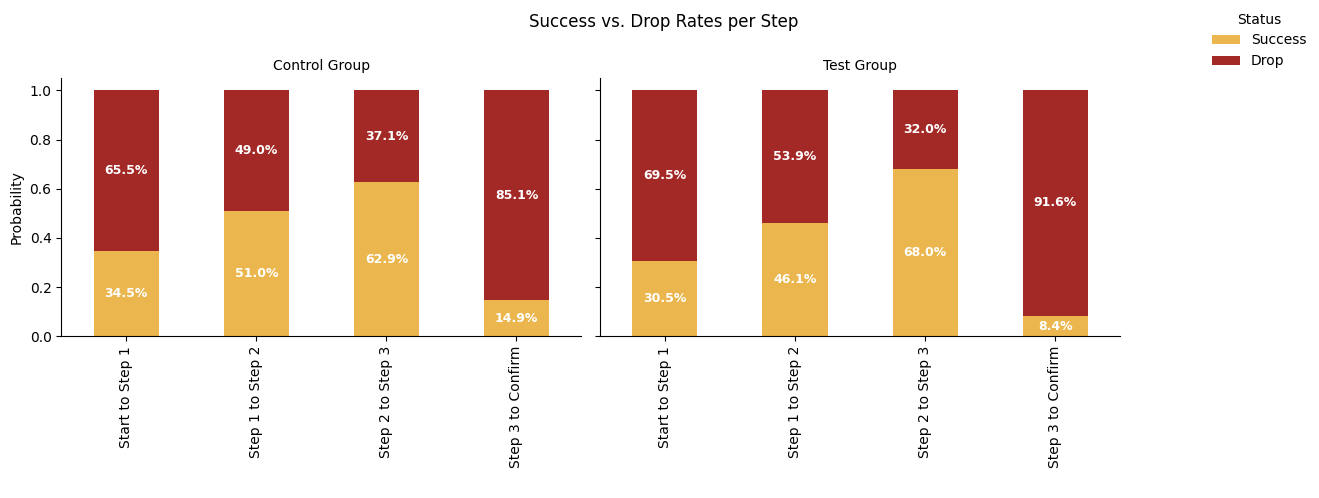

In [50]:
#Stacked graph of success vs drop  
g = sns.FacetGrid(final_plot_df, col="Variation", height=5, aspect=1.2)

def stacked_bar(data, **kwargs):
    ax = plt.gca()
    pivot = data.pivot(index='Step', columns='Status', values='Probability')
    pivot = pivot[['Success', 'Drop']]
    
    pivot.plot(kind='bar', stacked=True, ax=ax, color=['#eab64d','#a32927'], legend=True)
    
    for container in ax.containers:
        labels = [f'{v.get_height():.1%}' if v.get_height() > 0.05 else '' for v in container]
        ax.bar_label(container, labels=labels, label_type='center', color='white', fontweight='bold', fontsize=9)

g.map_dataframe(stacked_bar)

g.set_axis_labels(" ", "Probability")
g.set_titles("{col_name} Group")

handles, labels = plt.gca().get_legend_handles_labels()
g.add_legend(dict(zip(labels, handles)), title="Status", loc='upper right')

for ax in g.axes.flat:
    if ax.get_legend():
        ax.get_legend().remove()

plt.subplots_adjust(top=0.85, right=0.85)
g.fig.suptitle('Success vs. Drop Rates per Step')
plt.show()

In [53]:
#Error Rate Step by Step 1. Data prep 
step_errors = (df_err.groupby (['Variation', 'process_step', 'error'])['visit_id'].nunique().unstack(fill_value=0).reset_index())
step_errors.columns=['Variation','Step', 'Success_Transitions','Error_Occurances']
step_errors['Total_Interactions'] = step_errors['Success_Transitions']+step_errors['Error_Occurances']
step_errors['Error_Rate']=step_errors['Error_Occurances']/step_errors['Total_Interactions']
step_errors['Success_Rate']=1-step_errors['Error_Rate']

In [63]:
#Error Rate Step by Step 2. Melting the data to prep for stacked chart 
error_plot_df = step_errors.melt(id_vars=['Variation', 'Step'], value_vars=['Success_Rate', 'Error_Rate'], var_name='Status', value_name='Probability')
error_plot_df['Status']=error_plot_df['Status'].replace({'Success_Rate':'Clean Step', 'Error Rate': 'Error/Backward Step'})
error_plot_df

,Variation,Step,Status,Probability
0,Control,confirm,Clean Step,1.000000
1,Control,start,Clean Step,0.880465
2,Control,step_1,Clean Step,0.923285
3,Control,step_2,Clean Step,0.918005
4,Control,step_3,Clean Step,0.992946
5,Test,confirm,Clean Step,1.000000
6,Test,start,Clean Step,0.796287
7,Test,step_1,Clean Step,0.911028
8,Test,step_2,Clean Step,0.929915
9,Test,step_3,Clean Step,0.998694


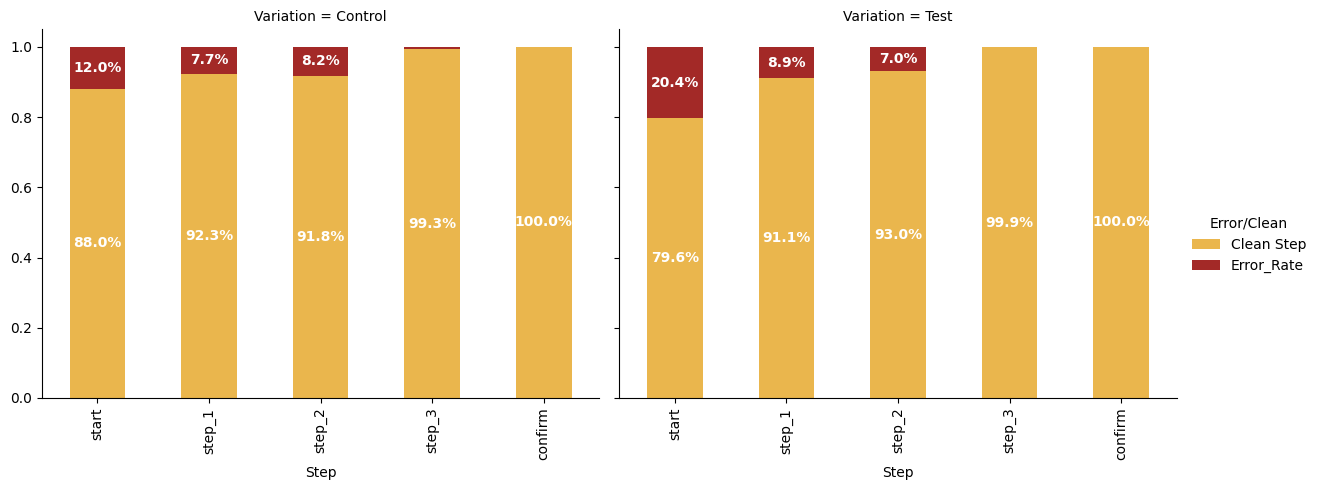

In [65]:
#Error Rate Step by Step 3. Creating Stacked Chart 

step_order_list = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
error_plot_df['Step'] = pd.Categorical(error_plot_df['Step'], categories=step_order_list, ordered=True)

g = sns.FacetGrid(error_plot_df, col="Variation", height=5, aspect=1.2)

def stacked_error_bar(data, **kwargs):
    ax = plt.gca()
    pivot = data.pivot(index='Step', columns='Status', values='Probability')
    pivot[['Clean Step', 'Error_Rate']].plot(kind='bar', stacked=True, ax=ax, 
                                                 color=['#eab64d','#a32927'], legend=False)
    
    for container in ax.containers:
        labels = [f'{v.get_height():.1%}' if v.get_height() > 0.02 else '' for v in container]
        ax.bar_label(container, labels=labels, label_type='center', color='white', fontweight='bold')

g.map_dataframe(stacked_error_bar)
g.add_legend(title="Error/Clean")
plt.show()